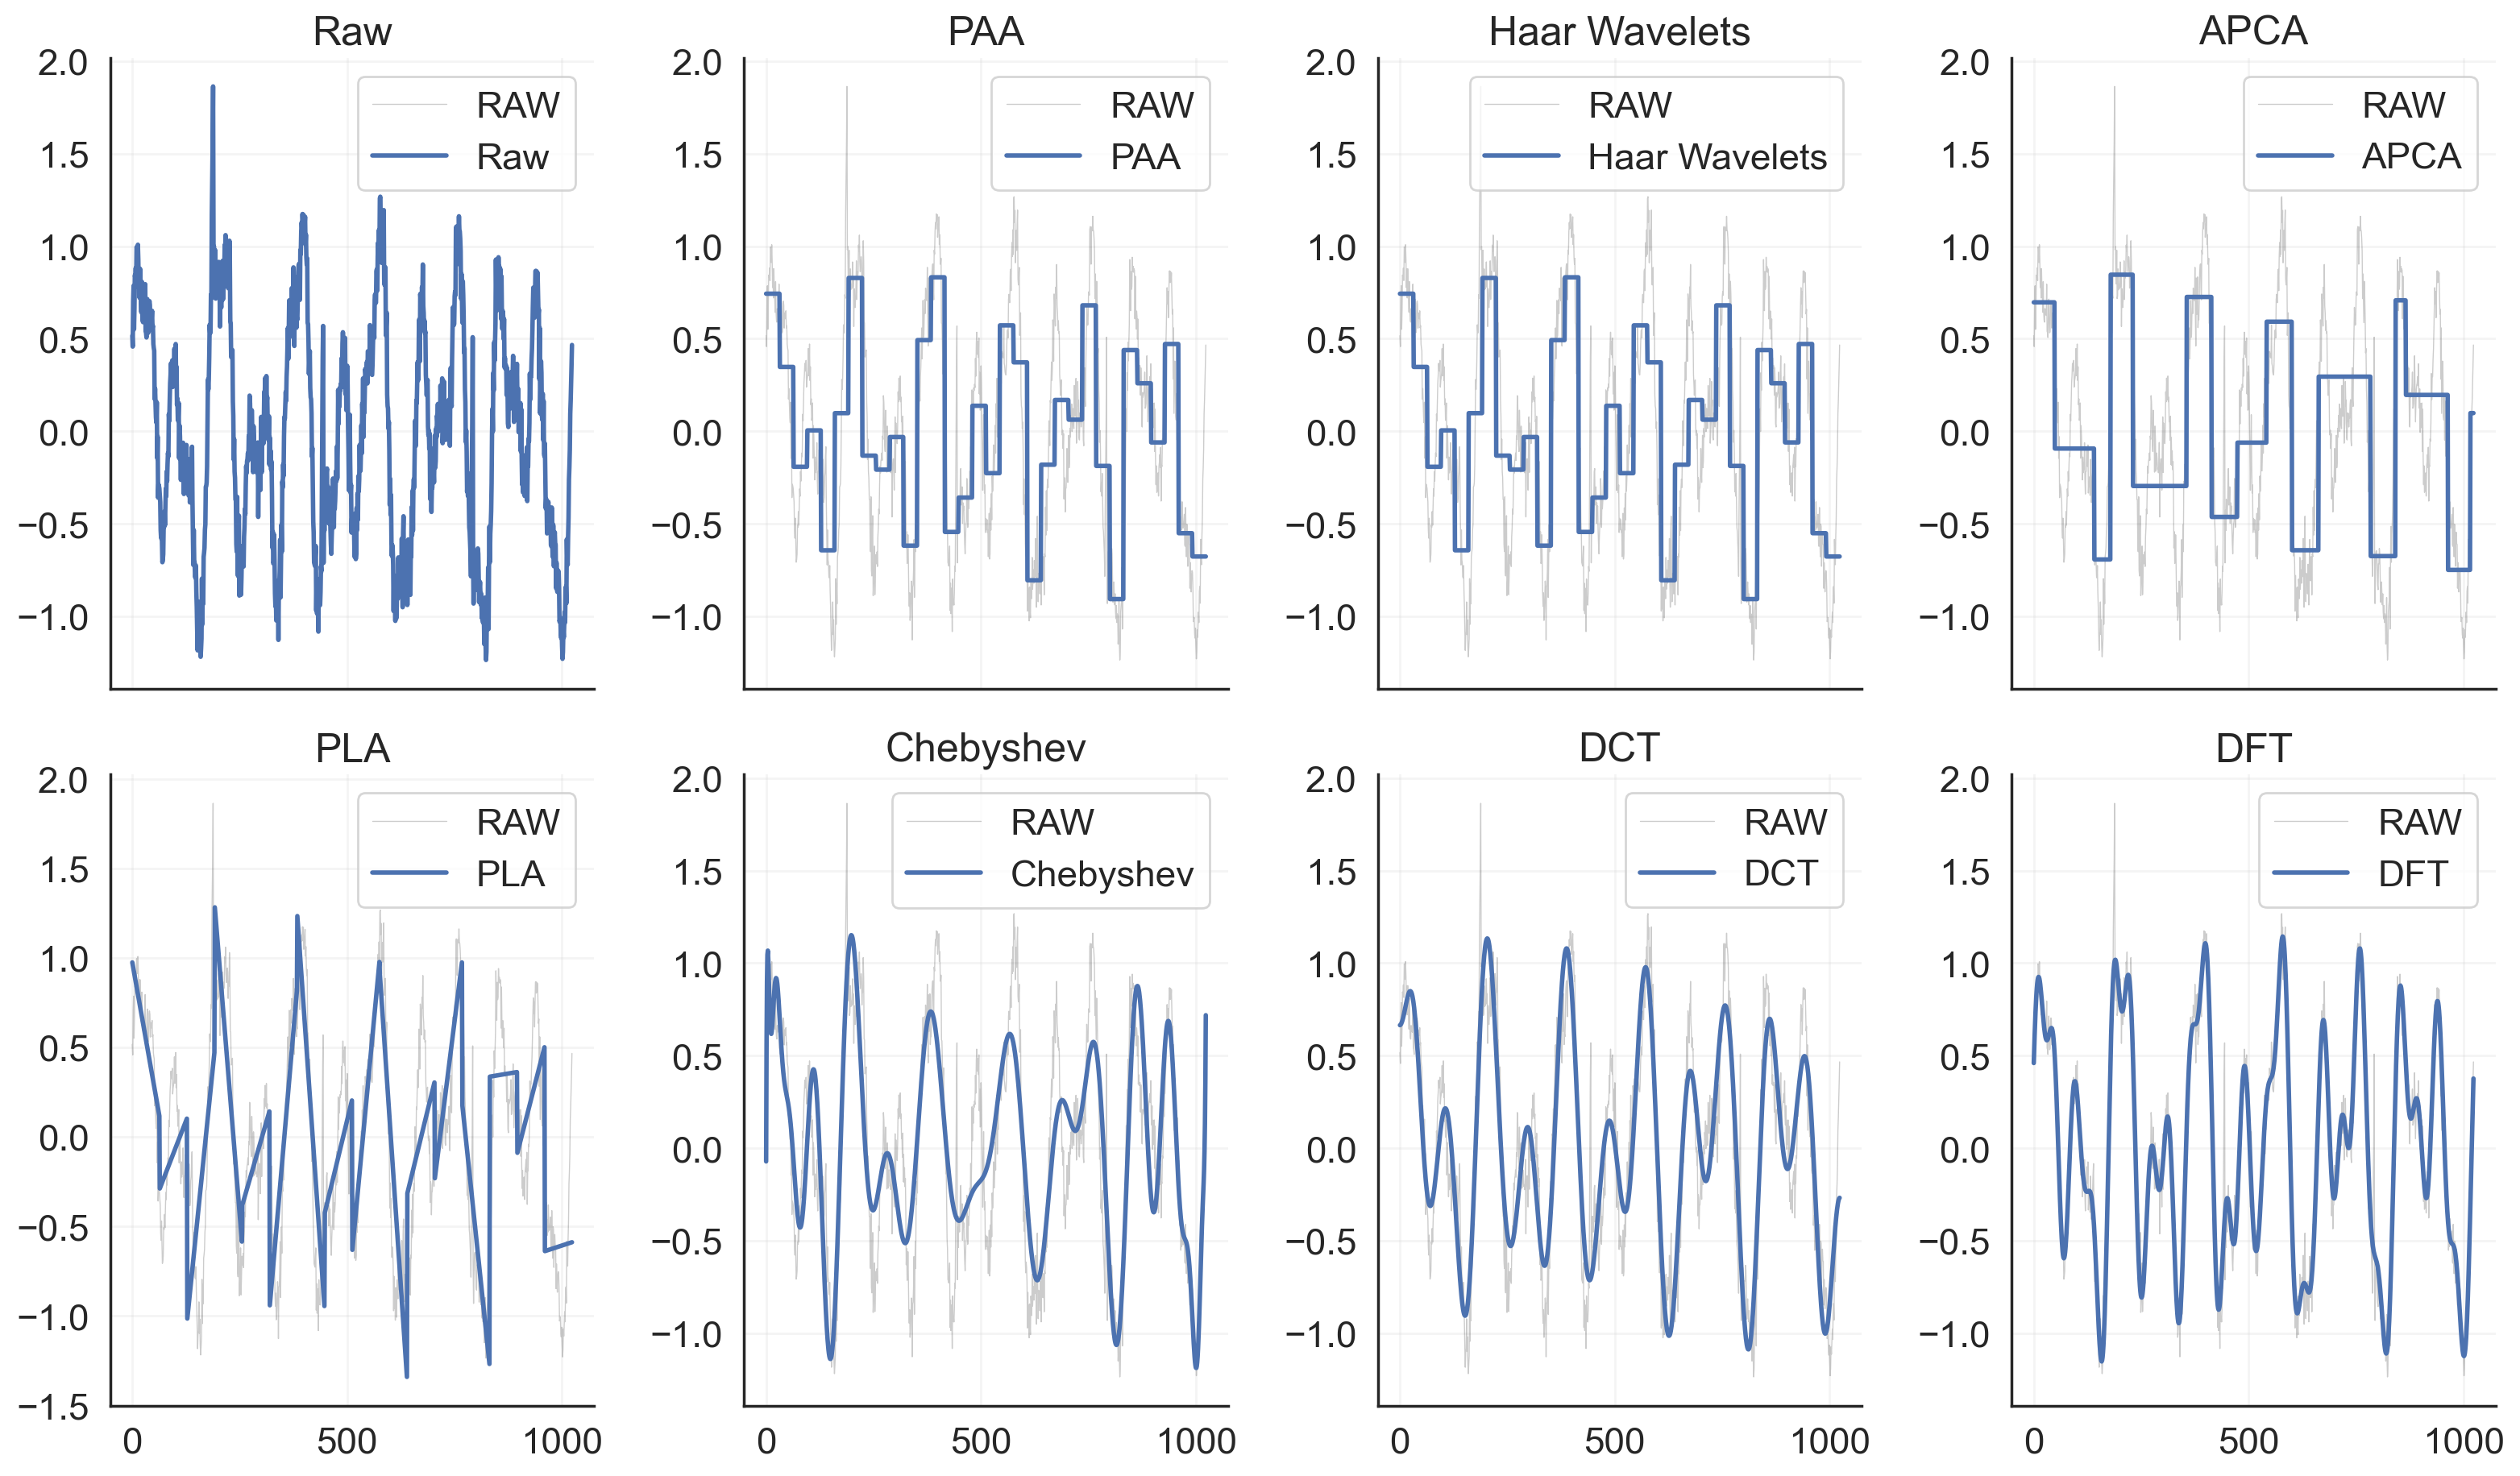

In [141]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct, idct
import pywt 
from numpy.polynomial.chebyshev import chebfit, chebval

rng = np.random.default_rng(42)

# ---------------------------------------------------------------------
# Synthetic signal
# ---------------------------------------------------------------------
def make_signal(n=1024, noise_std=0.10):
    t = np.linspace(0, 1, n, endpoint=False)
    x = (
        0.5 * np.sin(2 * np.pi * 6 * t) +
        0.6 * np.sin(2 * np.pi * 11 * t + 0.4) +
        0.3 * np.sin(2 * np.pi * 23 * t + 1.0)
    )
    # Add a few transients
    spikes = np.zeros_like(x)
    for pos in [int(0.18*n), int(0.43*n), int(0.77*n)]:
        spikes[pos:pos+5] += np.linspace(0, 1.2, 5)
    x = x + spikes + noise_std * rng.standard_normal(n)
    return x

# ---------------------------------------------------------------------
# 1) PAA (Piecewise Aggregate Approximation)
# ---------------------------------------------------------------------
def reconstruct_paa(x, segments=32):
    n = len(x)
    # Split as evenly as possible, take mean in each chunk
    idxs = np.array_split(np.arange(n), segments)
    means = np.array([x[idx].mean() for idx in idxs])
    # Reconstruct piecewise-constant
    x_hat = np.concatenate([np.full(len(idx), m) for idx, m in zip(idxs, means)])
    return x_hat

# ---------------------------------------------------------------------
# 2) APCA (Adaptive Piecewise Constant Approximation)
#    Simple top-down splitter using SSE reduction with prefix sums.
# ---------------------------------------------------------------------
def _segment_sse(prefix_sum, prefix_sqsum, a, b):
    # SSE for constant fit in [a, b) with mean over that interval
    length = b - a
    if length <= 0: 
        return 0.0
    s = prefix_sum[b] - prefix_sum[a]
    ss = prefix_sqsum[b] - prefix_sqsum[a]
    mean = s / length
    return ss - 2*mean*s + length*(mean**2)

def reconstruct_apca(x, k_segments=32, min_len=8):
    n = len(x)
    if k_segments <= 1:
        return np.full(n, x.mean())
    # Prefix sums for O(1) SSE
    prefix_sum = np.zeros(n+1)
    prefix_sqsum = np.zeros(n+1)
    prefix_sum[1:] = np.cumsum(x)
    prefix_sqsum[1:] = np.cumsum(x**2)
    # Start with single segment [0, n)
    segments = [(0, n)]
    # While fewer than k segments, split the segment that gives best SSE reduction
    while len(segments) < k_segments:
        best_gain = 0.0
        best_choice = None
        # Evaluate splitting each segment
        for si, (a, b) in enumerate(segments):
            if b - a >= 2*min_len:
                sse_parent = _segment_sse(prefix_sum, prefix_sqsum, a, b)
                # Search best split
                # (coarse scan step for speed; refine around best if desired)
                step = max((b - a)//64, 1)
                for c in range(a + min_len, b - min_len + 1, step):
                    sse_left  = _segment_sse(prefix_sum, prefix_sqsum, a, c)
                    sse_right = _segment_sse(prefix_sum, prefix_sqsum, c, b)
                    gain = sse_parent - (sse_left + sse_right)
                    if gain > best_gain:
                        best_gain = gain
                        best_choice = (si, c)
        if best_choice is None:
            break
        si, c = best_choice
        a, b = segments[si]
        segments[si:si+1] = [(a, c), (c, b)]
    # Reconstruct piecewise-constant
    x_hat = np.empty_like(x)
    for a, b in segments:
        x_hat[a:b] = x[a:b].mean()
    return x_hat

# ---------------------------------------------------------------------
# 3) DFT (keep K lowest-frequency rFFT bins)
# ---------------------------------------------------------------------
def reconstruct_dft(x, K=32):
    n = len(x)
    X = np.fft.rfft(x)
    # Keep first K frequency bins (including DC); zero the rest
    X_trunc = np.zeros_like(X)
    K_eff = min(K, X.size)
    X_trunc[:K_eff] = X[:K_eff]
    x_hat = np.fft.irfft(X_trunc, n=n)
    return x_hat

# ---------------------------------------------------------------------
# 4) Haar Wavelets (keep only approximation at level L)
# ---------------------------------------------------------------------
def reconstruct_haar(x, wavelet='haar', level=3):
    w = pywt.Wavelet(wavelet)
    level = min(level, pywt.dwt_max_level(len(x), w.dec_len))
    coeffs = pywt.wavedec(x, wavelet=wavelet, level=level, mode='symmetric')
    coeffs_kept = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
    x_hat = pywt.waverec(coeffs_kept, wavelet=wavelet, mode='symmetric')
    return x_hat[:len(x)]

# ---------------------------------------------------------------------
# 5) Piecewise Linear Approximation (uniform segments; LS fit per segment)
# ---------------------------------------------------------------------
def reconstruct_pla(x, segments=32):
    n = len(x)
    idxs = np.array_split(np.arange(n), segments)
    x_hat = np.empty_like(x, dtype=float)
    for idx in idxs:
        A = np.vstack([idx-idx[0], np.ones(len(idx))]).T
        a, b = np.linalg.lstsq(A, x[idx])[0]
        x_hat[idx] = a * (idx-idx[0]) + b
    return x_hat

# ---------------------------------------------------------------------
# 6) Chebyshev Polynomials (degree d)
# ---------------------------------------------------------------------
def reconstruct_chebyshev(x, degree=20):
    n = len(x)
    # Map indices to [-1, 1]
    z = np.linspace(-1, 1, n)
    coeffs = chebfit(z, x, deg=degree)
    x_hat = chebval(z, coeffs)
    return x_hat

# ---------------------------------------------------------------------
# 7) DCT (Type-II forward, Type-III inverse, orthonormal)
# ---------------------------------------------------------------------
def reconstruct_dct(x, K=32):
    # DCT-II with orthonormal scaling
    X = dct(x, type=2, norm='ortho')
    X_trunc = np.zeros_like(X)
    K_eff = min(K, len(X))
    X_trunc[:K_eff] = X[:K_eff]
    # IDCT-III with orthonormal scaling
    x_hat = idct(X_trunc, type=2, norm='ortho')  # idct with type=2 is inverse of dct type=2 under 'ortho'
    return x_hat

# ---------------------------------------------------------------------
# Demo
# ---------------------------------------------------------------------
if __name__ == "__main__":
    sns.set(font_scale=1.5)
    sns.set_style("white")
    
    n = 1024
    x = make_signal(n=n)

    # Parameters per method
    PAA_SEG = 32
    APCA_SEG = 16
    DFT_K   = 32
    HAAR_L  = int(np.log2(32))
    PLA_SEG = 16
    CHEB_D  = 32
    DCT_K   = 40

    recon = {
        "Raw": x,
        "PAA": reconstruct_paa(x, PAA_SEG),
        "Haar Wavelets": reconstruct_haar(x, wavelet='haar', level=HAAR_L),
        "APCA": reconstruct_apca(x, k_segments=APCA_SEG, min_len=4),
        "PLA": reconstruct_pla(x, segments=PLA_SEG),
        "Chebyshev": reconstruct_chebyshev(x, degree=CHEB_D),
        "DCT": reconstruct_dct(x, K=DCT_K),
        "DFT": reconstruct_dft(x, K=DFT_K),
    }

    fig, axes = plt.subplots(2, 4, figsize=(16, 10), sharex=True)
    axes = axes.ravel()
    for ax, (name, xhat) in zip(axes, recon.items()):
        sns.lineplot(data=x, ax = ax, lw=0.5, alpha=0.2, label="RAW", color="black")
        sns.lineplot(data=xhat, ax = ax, lw=2, label=name)
        sns.despine()
        ax.set_title(name)
        ax.grid(alpha=0.2)
    
    # Hide any unused subplot (if any)
    for i in range(len(recon), len(axes)):
        axes[i].axis("off")

    # handles, labels = axes[1].get_legend_handles_labels()
    # fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.show()

plt.savefig("images/summarizations.pdf", bbox_inches='tight')
plt.show()
